In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns', None)

# Load The Datasets

In [55]:
df_train = pd.read_csv('./data/train.csv')
df_features = pd.read_csv('./data/features.csv')
df_test = pd.read_csv('./data/test.csv')
df_stores = pd.read_csv('./data/stores.csv')
df_sample_submission = pd.read_csv('./data/sampleSubmission.csv')

print("train data shape is {}" .format(df_train.shape))
print("features data shape is {}" .format(df_features.shape))
print("test data shape is {}" .format(df_test.shape))
print("stores data shape is {}" .format(df_stores.shape))
print("sample_submission data shape is {}" .format(df_sample_submission.shape))

train data shape is (421570, 5)
features data shape is (8190, 12)
test data shape is (115064, 4)
stores data shape is (45, 3)
sample_submission data shape is (115064, 2)


In [56]:
df_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [57]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [58]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [59]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


# Merge Datasets

In [60]:
# Merge df_train and df_test with df_features
merged_df = pd.merge(df_train, df_features, on=['Store', 'Date'], how='left')
test_merged_df = pd.merge(df_test, df_features, on=['Store', 'Date'], how='left')

In [61]:
# Merge df_train and df_test with df_stores
merged_df = pd.merge(merged_df, df_stores, on=['Store'], how='inner')
test_merged_df = pd.merge(test_merged_df, df_stores, on=['Store'], how='inner')

In [62]:
# Check for any errors
merged_df.shape
test_merged_df.shape

(115064, 16)

In [63]:
merged_df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
dtype: int64

In [64]:
merged_df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [65]:
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [66]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  IsHoliday_y   421570 non-null  bool   
 15  Type          421570 non-null  object 
 16  Size          421570 non-null  int64  
dtypes: bool(2), float64(10), int64(3), object(2)
mem

In [67]:
# create a new column, date_parsed, with the parsed dates
merged_df['date_parsed'] = pd.to_datetime(merged_df['Date'], format="%Y-%m-%d")
test_merged_df['date_parsed'] = pd.to_datetime(test_merged_df['Date'], format="%Y-%m-%d")

In [68]:
# drop columns
merged_df = merged_df.drop(columns='Date')
test_merged_df = test_merged_df.drop(columns='Date')
merged_df = merged_df.drop(columns=['IsHoliday_y'])
test_merged_df = test_merged_df.drop(columns=['IsHoliday_y'])
merged_df = merged_df.rename(columns=dict(IsHoliday_x='IsHoliday'))
test_merged_df = test_merged_df.rename(columns=dict(IsHoliday_x='IsHoliday'))

# Data Visualization

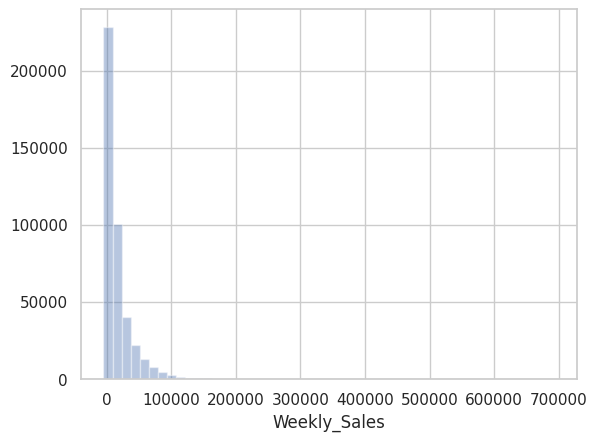

In [69]:
# Distribution of values in target feature
sns.distplot(df_train.get('Weekly_Sales'), kde=False)
plt.show()

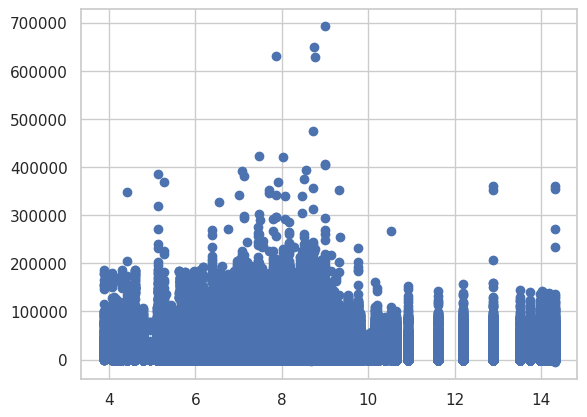

In [70]:
plt.scatter(x='Unemployment', y='Weekly_Sales', data=merged_df)

In [71]:
merged_df.query('Weekly_Sales > 600000')
#95373, 95425, 337961, 338013

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,date_parsed
95373,10,72,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,2010-11-26
95425,10,72,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,2011-11-25
337961,35,72,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,2010-11-26
338013,35,72,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,2011-11-25


In [72]:
ids_to_drop = [95373, 95425, 337961, 338013]
merged_df = merged_df.drop(ids_to_drop)

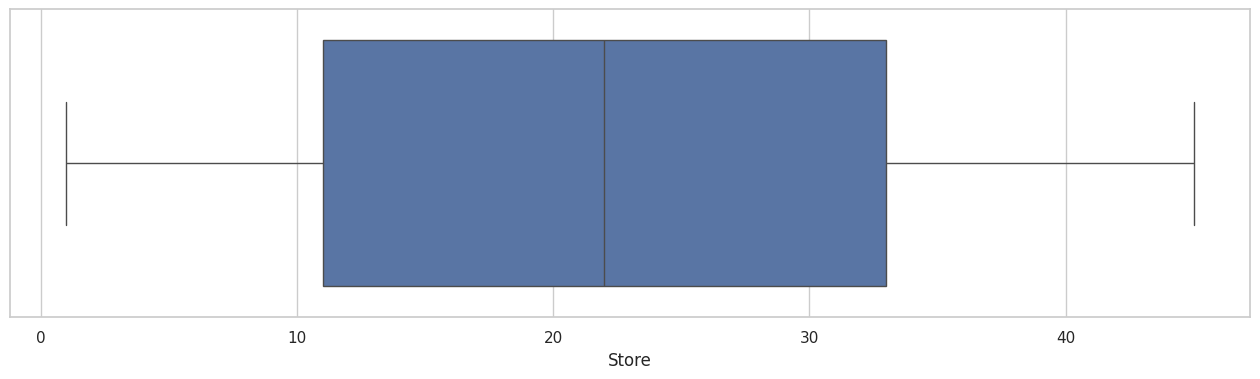

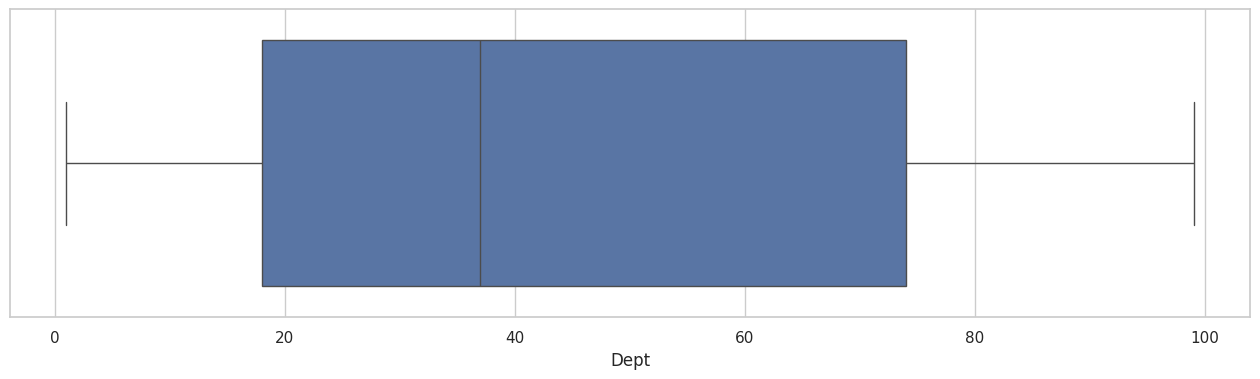

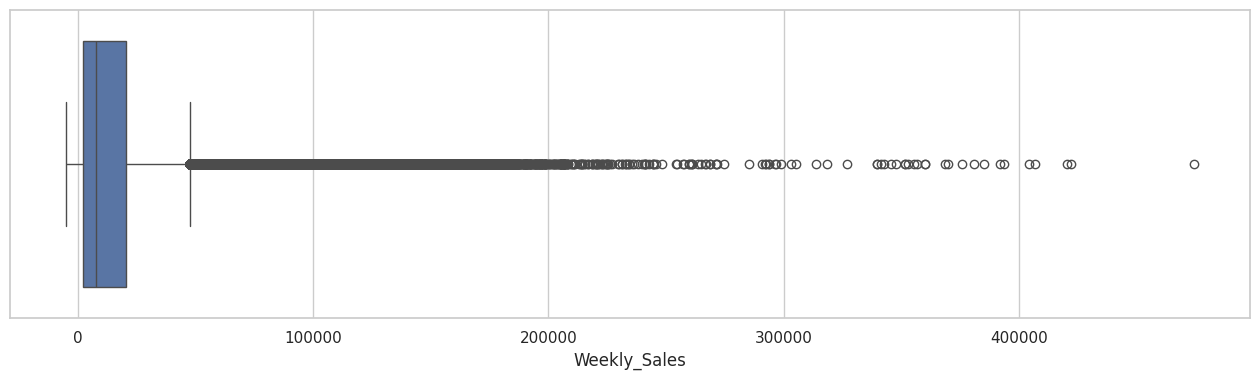

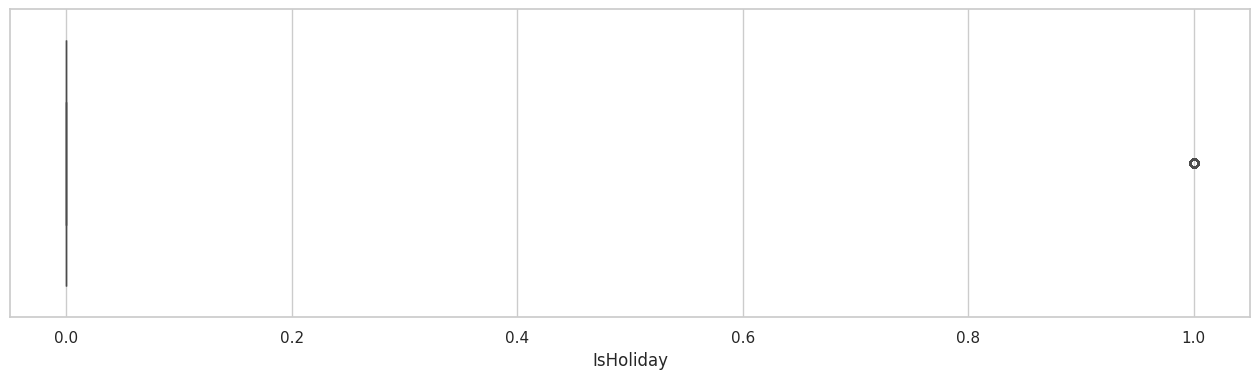

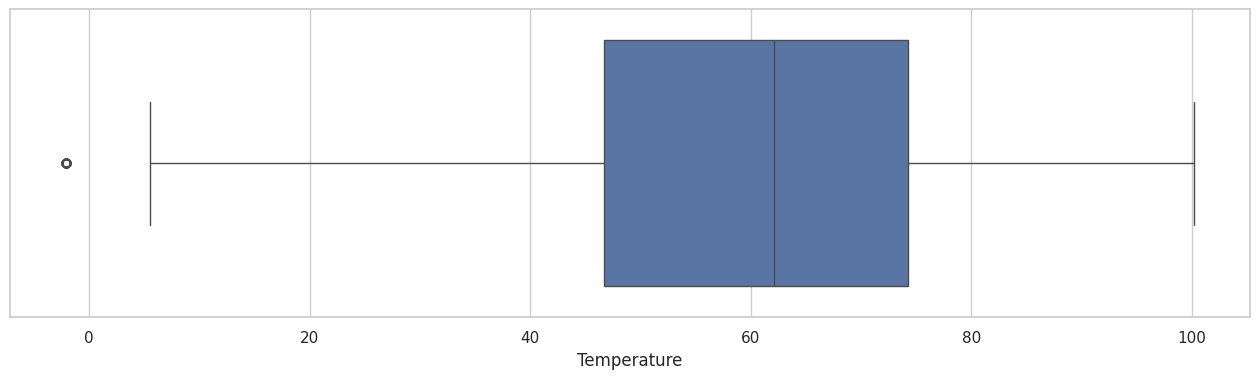

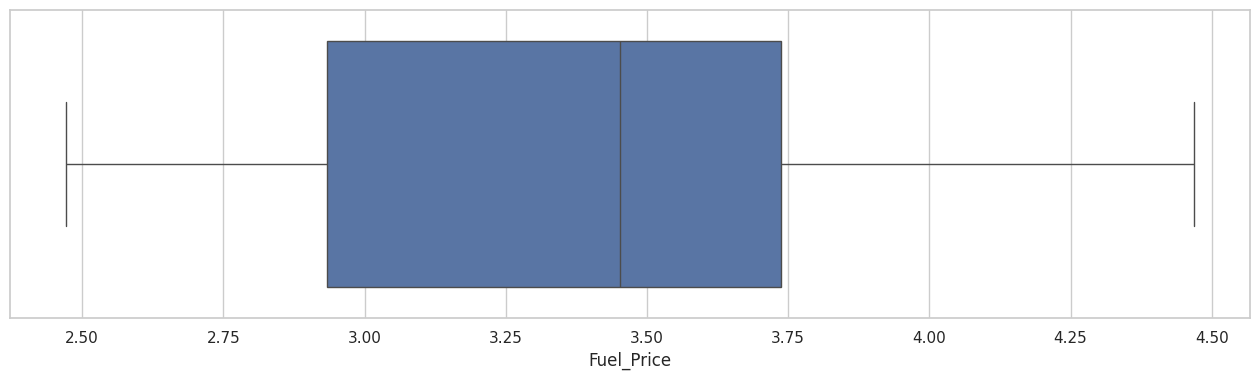

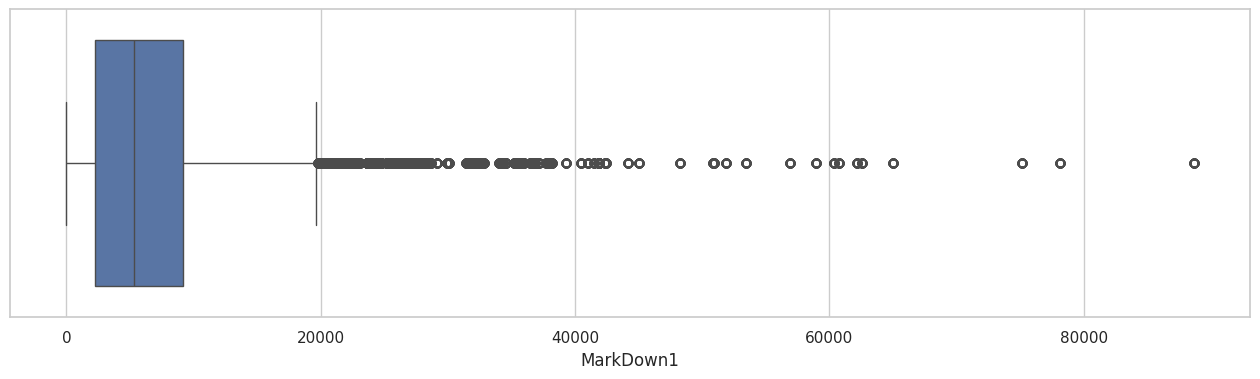

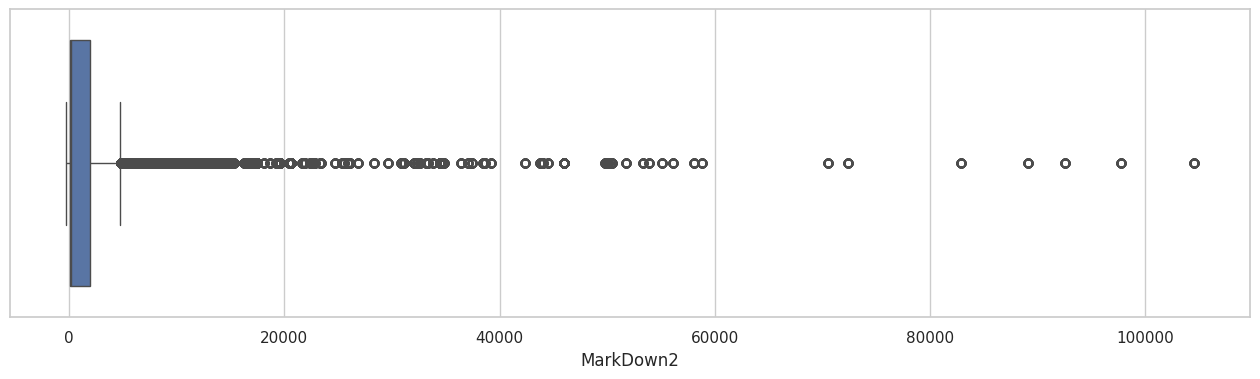

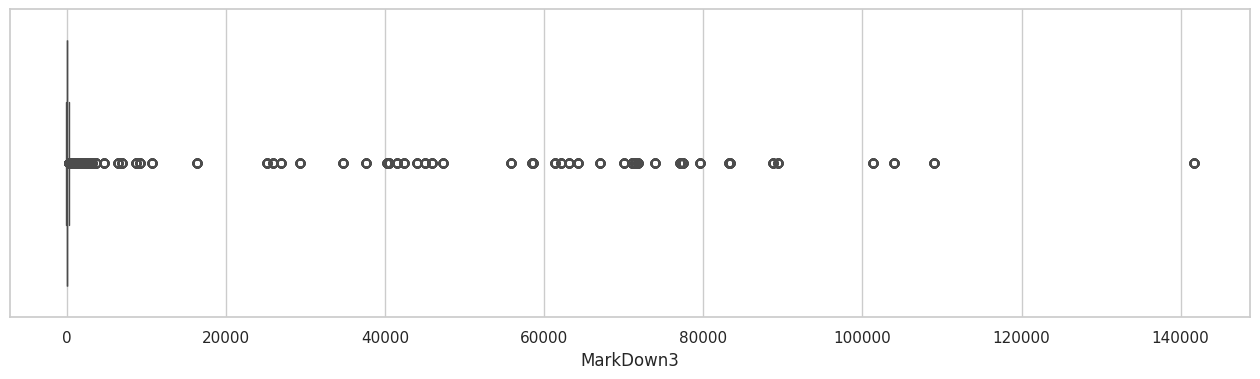

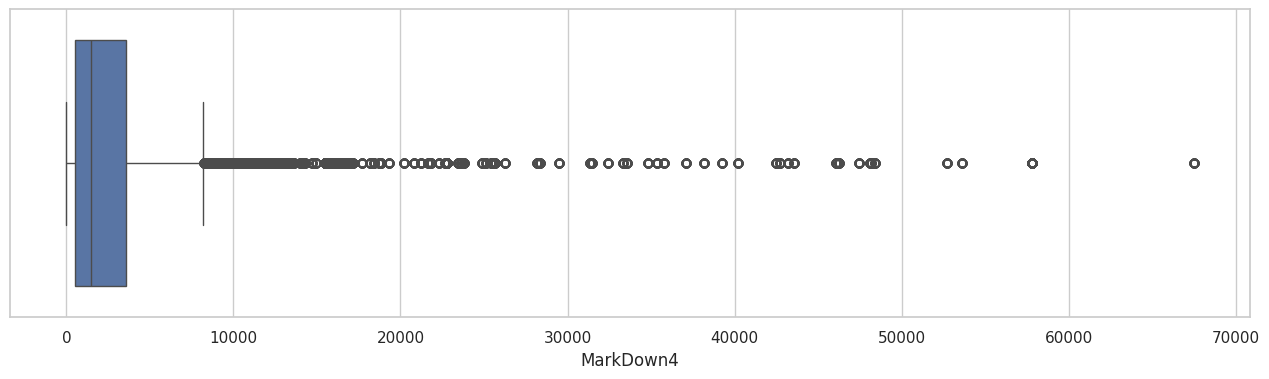

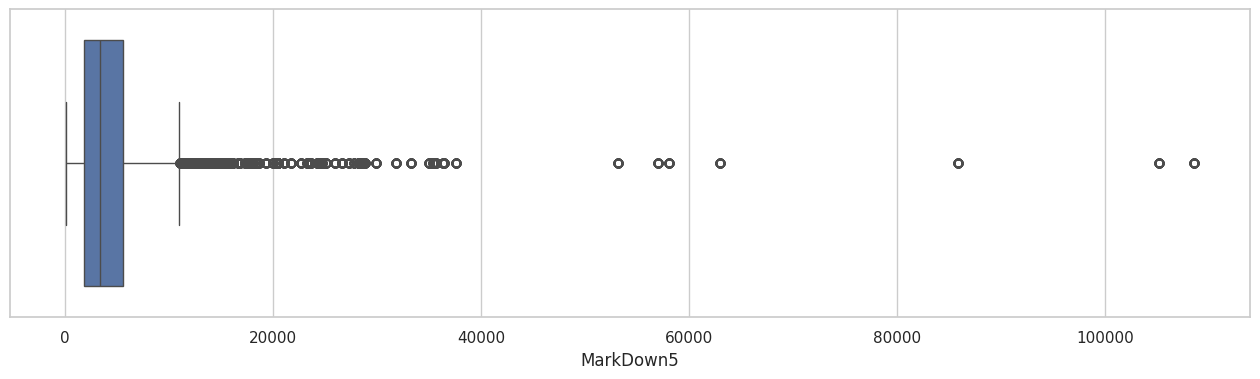

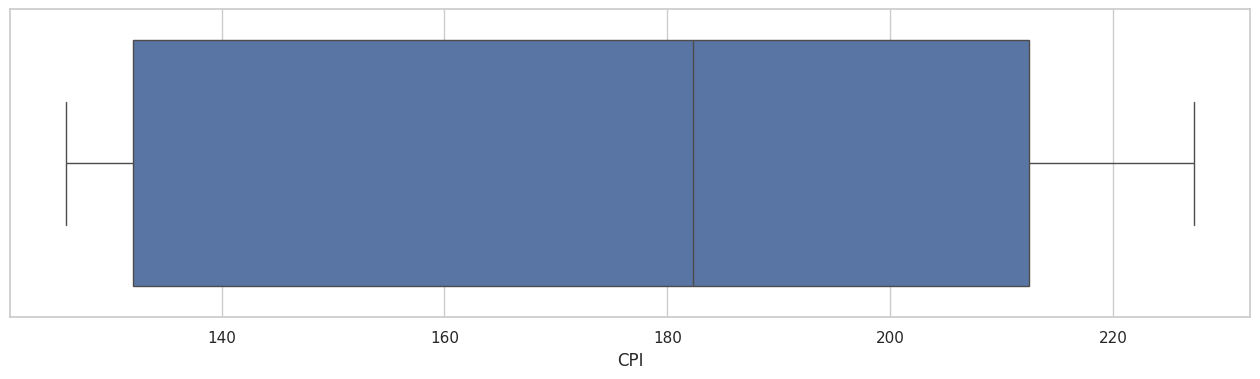

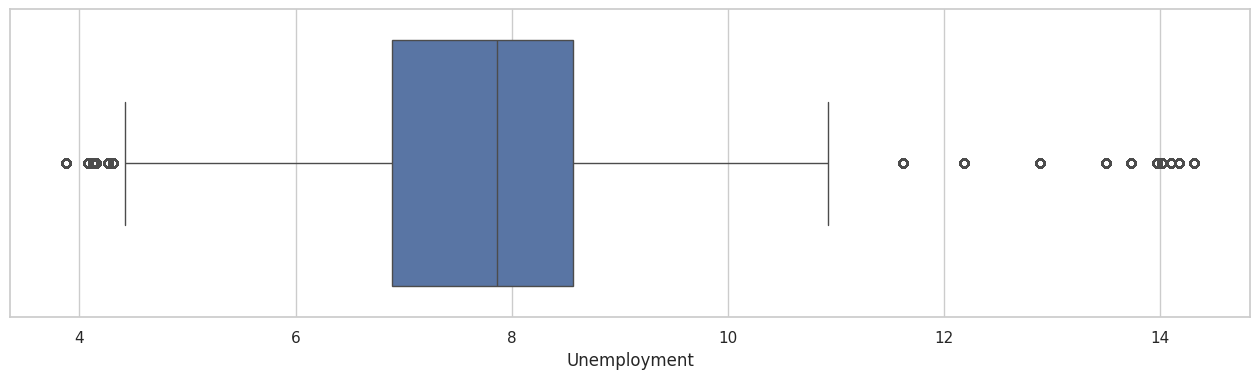

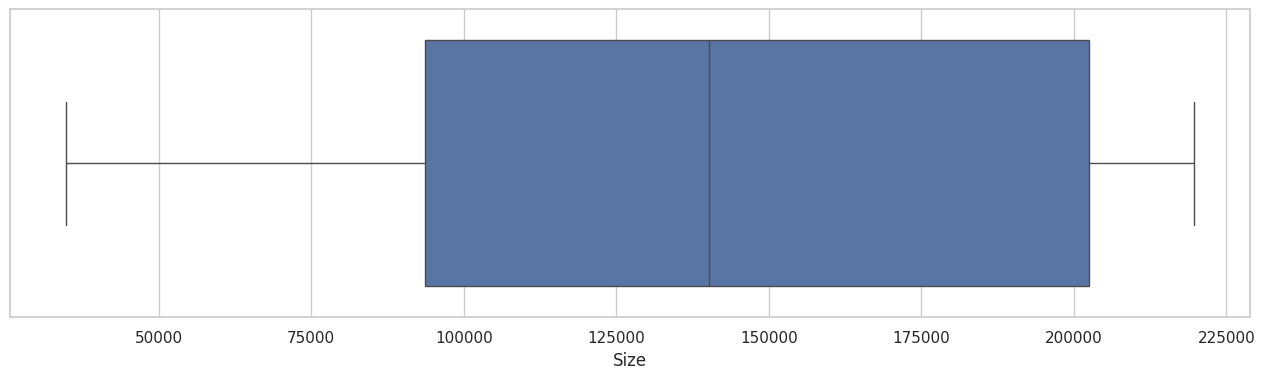

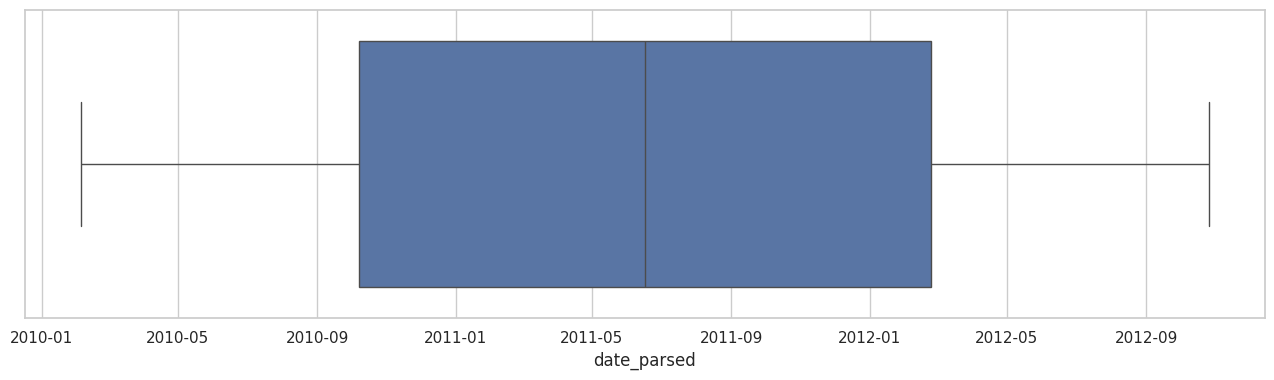

In [73]:
# Find outliers for all numerical dataset (before handling missing values)

numerical_df = merged_df.select_dtypes(exclude=['object'])

for column in numerical_df:
  plt.figure(figsize=(16, 4))
  sns.set_theme(style="whitegrid")
  sns.boxplot(numerical_df[column], orient='h')
  plt.xlabel(column)
  plt.show()

# Data Cleaning

In [74]:
merged_df['MarkDown1'].fillna(merged_df.MarkDown1.mean(), inplace=True)
merged_df['MarkDown2'].fillna(merged_df.MarkDown1.mean(), inplace=True)
merged_df['MarkDown3'].fillna(merged_df.MarkDown1.mean(), inplace=True)
merged_df['MarkDown4'].fillna(merged_df.MarkDown1.mean(), inplace=True)
merged_df['MarkDown5'].fillna(merged_df.MarkDown1.mean(), inplace=True)

In [75]:
test_merged_df['MarkDown1'].fillna(test_merged_df.MarkDown1.mean(), inplace=True)
test_merged_df['MarkDown2'].fillna(test_merged_df.MarkDown1.mean(), inplace=True)
test_merged_df['MarkDown3'].fillna(test_merged_df.MarkDown1.mean(), inplace=True)
test_merged_df['MarkDown4'].fillna(test_merged_df.MarkDown1.mean(), inplace=True)
test_merged_df['MarkDown5'].fillna(test_merged_df.MarkDown1.mean(), inplace=True)

In [76]:
merged_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,date_parsed
0,1,1,24924.50,False,42.31,2.572,7246.506372,7246.506372,7246.506372,7246.506372,7246.506372,211.096358,8.106,A,151315,2010-02-05
1,1,1,46039.49,True,38.51,2.548,7246.506372,7246.506372,7246.506372,7246.506372,7246.506372,211.242170,8.106,A,151315,2010-02-12
2,1,1,41595.55,False,39.93,2.514,7246.506372,7246.506372,7246.506372,7246.506372,7246.506372,211.289143,8.106,A,151315,2010-02-19
3,1,1,19403.54,False,46.63,2.561,7246.506372,7246.506372,7246.506372,7246.506372,7246.506372,211.319643,8.106,A,151315,2010-02-26
4,1,1,21827.90,False,46.50,2.625,7246.506372,7246.506372,7246.506372,7246.506372,7246.506372,211.350143,8.106,A,151315,2010-03-05


In [77]:
test_merged_df.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,date_parsed
0,1,1,False,55.32,3.386,6766.44,5147.700000,50.82,3639.90,2737.42,223.462779,6.573,A,151315,2012-11-02
1,1,1,False,61.24,3.314,11421.32,3370.890000,40.28,4646.79,6154.16,223.481307,6.573,A,151315,2012-11-09
2,1,1,False,52.92,3.252,9696.28,292.100000,103.78,1133.15,6612.69,223.512911,6.573,A,151315,2012-11-16
3,1,1,True,56.23,3.211,883.59,4.170000,74910.32,209.91,303.32,223.561947,6.573,A,151315,2012-11-23
4,1,1,False,52.34,3.207,2460.03,7689.216439,3838.35,150.57,6966.34,223.610984,6.573,A,151315,2012-11-30


In [78]:
merged_df.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
date_parsed     0
dtype: int64

In [79]:
test_merged_df.isnull().sum()

Store               0
Dept                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1           0
MarkDown2           0
MarkDown3           0
MarkDown4           0
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
date_parsed         0
dtype: int64

In [80]:
# Fill nulls in test_merged_df
test_merged_df['CPI'] = test_merged_df.groupby('Store')['CPI'].transform(lambda x: x.fillna(x.mean()))
test_merged_df['Unemployment'] = test_merged_df.groupby('Store')['Unemployment'].transform(lambda x: x.fillna(x.mean()))

In [81]:
test_merged_df.isnull().sum()

Store           0
Dept            0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
date_parsed     0
dtype: int64

In [82]:
merged_df['IsHoliday'] = merged_df['IsHoliday'].astype(int)
test_merged_df["IsHoliday"] = test_merged_df["IsHoliday"].astype(int)

In [83]:
merged_df = pd.get_dummies(merged_df, columns=['Type'], prefix='Type')
test_merged_df = pd.get_dummies(test_merged_df, columns=['Type'], prefix='Type')

In [84]:
merged_df[["Type_A", "Type_B", "Type_C"]] = merged_df[["Type_A", "Type_B", "Type_C"]].astype(int)
test_merged_df[["Type_A", "Type_B", "Type_C"]] = test_merged_df[["Type_A", "Type_B", "Type_C"]].astype(int)

In [85]:
merged_df['Temperature'] = merged_df.Temperature.astype(float)
test_merged_df['Temperature'] = test_merged_df.Temperature.astype(float)

In [86]:
merged_df.dtypes

Store                    int64
Dept                     int64
Weekly_Sales           float64
IsHoliday                int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Size                     int64
date_parsed     datetime64[ns]
Type_A                   int64
Type_B                   int64
Type_C                   int64
dtype: object

In [87]:
merged_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,date_parsed,Type_A,Type_B,Type_C
0,1,1,24924.50,0,42.31,2.572,7246.506372,7246.506372,7246.506372,7246.506372,7246.506372,211.096358,8.106,151315,2010-02-05,1,0,0
1,1,1,46039.49,1,38.51,2.548,7246.506372,7246.506372,7246.506372,7246.506372,7246.506372,211.242170,8.106,151315,2010-02-12,1,0,0
2,1,1,41595.55,0,39.93,2.514,7246.506372,7246.506372,7246.506372,7246.506372,7246.506372,211.289143,8.106,151315,2010-02-19,1,0,0
3,1,1,19403.54,0,46.63,2.561,7246.506372,7246.506372,7246.506372,7246.506372,7246.506372,211.319643,8.106,151315,2010-02-26,1,0,0
4,1,1,21827.90,0,46.50,2.625,7246.506372,7246.506372,7246.506372,7246.506372,7246.506372,211.350143,8.106,151315,2010-03-05,1,0,0


# Feature Engineering

In [88]:
mark_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
merged_df['MarkDowns'] = merged_df[mark_cols].mean(axis=1)
mark_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
test_merged_df['MarkDowns'] = test_merged_df[mark_cols].mean(axis=1)

merged_df = merged_df.drop(columns=mark_cols)
test_merged_df = test_merged_df.drop(columns=mark_cols)

In [89]:
merged_df['Year'] = merged_df['date_parsed'].dt.year
merged_df['Month'] = merged_df['date_parsed'].dt.month
merged_df['Week'] = merged_df['date_parsed'].dt.isocalendar().week
merged_df['DayOfWeek'] = merged_df['date_parsed'].dt.day_of_week

test_merged_df['Year'] = test_merged_df['date_parsed'].dt.year
test_merged_df['Month'] = test_merged_df['date_parsed'].dt.month
test_merged_df['Week'] = test_merged_df['date_parsed'].dt.isocalendar().week
test_merged_df['DayOfWeek'] = test_merged_df['date_parsed'].dt.day_of_week

merged_df = merged_df.drop(columns='date_parsed')
test_merged_df = test_merged_df.drop(columns='date_parsed')

In [90]:
merged_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Type_A,Type_B,Type_C,MarkDowns,Year,Month,Week,DayOfWeek
0,1,1,24924.50,0,42.31,2.572,211.096358,8.106,151315,1,0,0,7246.506372,2010,2,5,4
1,1,1,46039.49,1,38.51,2.548,211.242170,8.106,151315,1,0,0,7246.506372,2010,2,6,4
2,1,1,41595.55,0,39.93,2.514,211.289143,8.106,151315,1,0,0,7246.506372,2010,2,7,4
3,1,1,19403.54,0,46.63,2.561,211.319643,8.106,151315,1,0,0,7246.506372,2010,2,8,4
4,1,1,21827.90,0,46.50,2.625,211.350143,8.106,151315,1,0,0,7246.506372,2010,3,9,4


# Building Model

In [91]:
X = merged_df.drop('Weekly_Sales', axis=1)
y = merged_df['Weekly_Sales']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [93]:
XGB = XGBRegressor(random_state=42)

In [94]:

param_dist = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}


In [95]:
# Fit XGBoost with GridSearchCV
xgb_cv = RandomizedSearchCV(
    XGB,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42
)

In [96]:
xgb_cv.fit(X_train, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.8, 0.9, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.05, 0.1, ...], 'max_depth': [3, 5, ...], ...}"
,n_iter,20
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [97]:
# Evaluate RMSE on validation
np.sqrt(-1 * xgb_cv.best_score_)

np.float64(3854.9818094980137)

In [98]:
# Predict directly with best XGB model
y_pred_xgb = xgb_cv.best_estimator_.predict(X_test)

In [99]:
# Calculate RMSE on test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("Test RMSE:", rmse_test)

Test RMSE: 3820.0139487570377


In [100]:
best_xgb = xgb_cv.best_estimator_
best_xgb.fit(X, y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [101]:
y_pred_test = best_xgb.predict(test_merged_df)

In [102]:
# submission
sample_sub = pd.read_csv('./data/sampleSubmission.csv')
sample_sub['Weekly_Sales'] = y_pred_test
sample_sub.to_csv('submission.csv', index=False)